In [122]:
import numpy as np
from IPython.display import Image
import math
from numpy import random
from geneticalgorithm import geneticalgorithm as ga

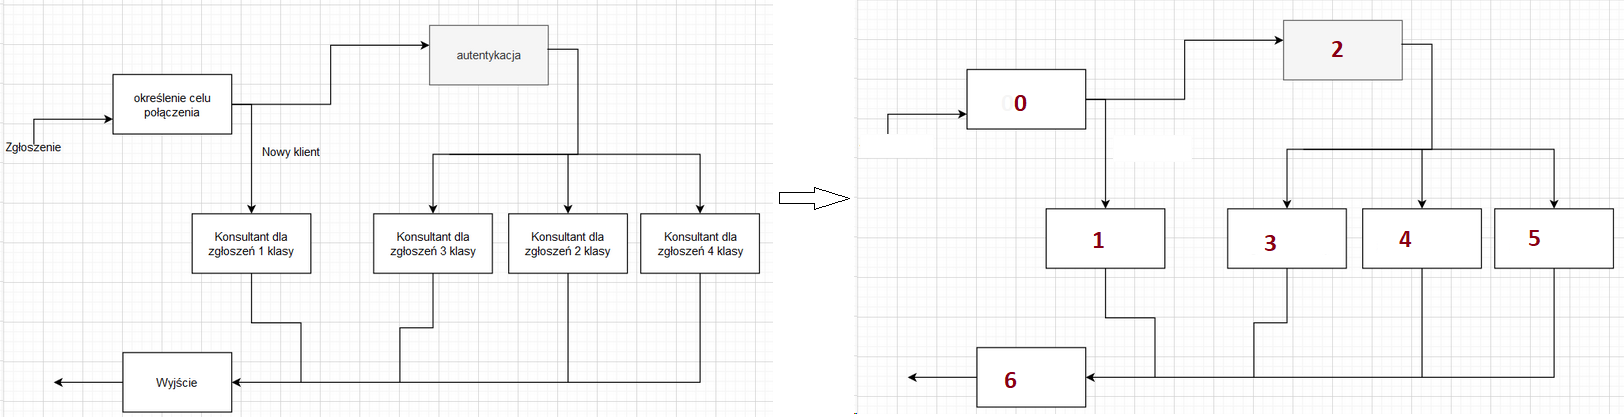

In [6]:
Image(filename='zdjecie.png') 

In [7]:
R = 4 # liczba klas
N = 6 # liczba systemów

In [8]:
# load lambda wejściowe
# rząd to klasa, kolumna to system (bez wejściowego)

lambda_0 = np.load('matrixy/lambda_0.npy')
lambda_0

array([[1.6, 0. , 0. , 0. , 0. , 0. ],
       [0. , 1.2, 0. , 0. , 0. , 0. ],
       [0. , 1.4, 0. , 0. , 0. , 0. ],
       [0. , 1.5, 0. , 0. , 0. , 0. ]])

In [9]:
# load prob. matrices for classes

p1 = np.load('matrixy/p1.npy')
p2 = np.load('matrixy/p2.npy')
p3 = np.load('matrixy/p3.npy')
p4 = np.load('matrixy/p4.npy')

# example of how the prob. matrix looks like

p1

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [10]:
p = [p1, p2, p3, p4]

In [11]:
# class_no od 1 do 4

def lambda_values_for_class(class_no):
    A = np.transpose(p[class_no-1]) - np.identity(len(p[class_no-1]))
    b = -lambda_0[class_no-1]
    
    return np.linalg.solve(A, b)

In [12]:
# example for class 2

lambda_values_for_class(2)

array([0. , 1.2, 1.2, 0. , 0. , 1.2])

In [13]:
def lambda_matrix():
    matrix = [lambda_values_for_class(r) for r in range(1,R+1)]
    return matrix

In [14]:
# chyba odwrotnie jest niz powinno 
# rows to klasy od 1 do 4, kolumny to systemy od 1 do 6

lambda_matrix = lambda_matrix()
lambda_matrix

[array([1.6, 0. , 0. , 0. , 0. , 1.6]),
 array([0. , 1.2, 1.2, 0. , 0. , 1.2]),
 array([0. , 1.4, 0. , 1.4, 0. , 1.4]),
 array([0. , 1.5, 0. , 0. , 1.5, 1.5])]

In [15]:
#service times
# mi to 1/czas wiec raczej male wartosci

mi = np.load('matrixy/mi.npy')
mi

array([[0.1  , 0.1  , 0.01 , 0.02 ],
       [0.8  , 0.8  , 0.8  , 0.8  ],
       [0.6  , 0.6  , 0.6  , 0.6  ],
       [0.33 , 0.33 , 0.33 , 0.33 ],
       [0.12 , 0.12 , 0.12 , 0.12 ],
       [0.218, 0.218, 0.218, 0.218]])

In [16]:
# kanały obsługi
# m od 0 do 5 systemu

m = [2, 13, 20, 10, 12, 12]

In [17]:
# intensywnosc obslugi
# od 0 do 5, r od 1 do 4

def calculate_ro_ir(i, r):
    if i == 0:
        return lambda_0[r-1][i]/(m[0]*mi[0][r-1])
    return lambda_matrix[r-1][i-1]/(m[i]*mi[i][r-1])

In [18]:
# example - ro for fifth system and fourth class

calculate_ro_ir(2,4)

0.125

In [19]:
def calculate_ro_i(i):
    return sum([calculate_ro_ir(i, r) for r in range(R)])

In [20]:
# example

calculate_ro_i(1)

0.15384615384615385

In [21]:
calculate_ro_ir(0, 1)

8.0

In [22]:
# system od 0 do 5, klasa od 1 do 4

def get_ro_matrix():
    ro_matrix = np.zeros((N, R))
    for r in range(1,R+1):
        for i in range(N):
            ro_matrix[i, r-1] = calculate_ro_ir(i, r)
    return ro_matrix

In [23]:
get_ro_matrix()

array([[8.        , 0.        , 0.        , 0.        ],
       [0.15384615, 0.        , 0.        , 0.        ],
       [0.        , 0.1       , 0.11666667, 0.125     ],
       [0.        , 0.36363636, 0.        , 0.        ],
       [0.        , 0.        , 0.97222222, 0.        ],
       [0.        , 0.        , 0.        , 0.5733945 ]])

In [24]:
# obliczanie prawdopodobieństwa, że w systemie i jest k zgłoszeń
# typ 1, m>1

# ten pierwszy wielki ułamek
def temp_first_part(k, m, ro):
    denom1 = sum([(((m * ro) ** k) / math.factorial(k)) for k in range(m-1)])
    denom2 = ((m*ro)**m) / (math.factorial(m)*(1-ro))
        
    return 1. / (denom1+denom2)

def calculate_pi_i(i, k):
    m_i = m[i]
    ro_i = calculate_ro_i(i)
    
    # to ten pierwszy duży ułamek
    first_part = temp_first_part(k, m_i, ro_i)
    
    if k > m_i:
        second_part = ((m_i**m_i)*(ro_i**k))/math.factorial(m_i)
    else:
        second_part = ((m_i*ro_i)**k)/math.factorial(k)
        
    return first_part * second_part
    

In [25]:
calculate_pi_i(4,10)

0.024635555960105075

In [26]:
# K - srednie liczby zgloszen klasy r w systemie i

def calculate_K_ir(i,r):
    m_i = m[i]
    ro_i = calculate_ro_i(i)
    ro_ir = calculate_ro_ir(i,r)
    mi_ro = m_i*ro_i
    
    first_part = m_i*ro_ir
    second_part = ro_ir/(1-ro_i)
    third_part = (mi_ro**m_i) / (math.factorial(m_i)*(1-ro_i))
    fourth_part = 1 / ( sum([(mi_ro**k_i) / math.factorial(k_i) for k_i in range(m_i-1)]) ) \
                  + ((mi_ro**m_i) / math.factorial(m_i))*(1 / (1 - ro_i))
    
    return first_part + second_part * third_part * fourth_part


In [27]:
def get_K_matrix():
    K_matrix = np.zeros((N, R))
    
    for r in range(1,R+1):
        for i in range(N):
            K_matrix[i, r-1] = calculate_K_ir(i, r)
    
    return K_matrix

In [28]:
# kurde czemu pierwsze ujemne hmm

get_K_matrix()

array([[-3.45236152e+02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 2.00000004e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  2.00014882e+00,  2.33350696e+00,
         2.50018603e+00],
       [ 0.00000000e+00,  3.65654593e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  7.99322557e+12,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         4.08954339e+03]])

In [62]:
# T - średni czas przebywania zgłoszenia klasy r w systemie i
# reguła Little'a? ze T = K/lambda
# klasa od 1 do 4, system od ...1 do ...6

def get_T_ir(i, r, K_matrix):
    if lambda_matrix[r-1][i-1] == 0: # i czy i-1? 
        return 0
    return K_matrix[i-1, r-1]/lambda_matrix[r-1][i-1]

def get_T_matrix():
    T_matrix = np.zeros((N, R))
    K_matrix = get_K_matrix()
    for r in range(R):
        for i in range(N):
            T_matrix[i,r] = get_T_ir(i, r, K_matrix)
    return T_matrix

In [63]:
T_matrix = get_T_matrix()
T_matrix

array([[ 2.72636226e+03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00, -2.15772595e+02,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.66679068e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

In [91]:
# W - sredni czas oczekiwania zgłoszenia klasy r w kolejce
# zakładając, że współczynniki obsługi są niezależne od liczby zgłoszeń
# W = T - 1/mi

def get_W_matrix():
    W_matrix = np.zeros((N, R))
    W_matrix = T_matrix - 1/mi2
    W_matrix[W_matrix<0] = 0 # czy to jest dozwolone? 
    return W_matrix

In [95]:
W_matrix = get_W_matrix()
W_matrix

array([[2.72536226e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.63648765e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [100]:
# Q - średnia długość kolejki
# regula Little'a (chyba)
# Q = lambda*W

def get_Q_matrix():
    Q_matrix = np.zeros((N, R))
    for r in range(R):
        for i in range(N):
            Q_matrix[i,r] = lambda_matrix[r][i]*W_matrix[i,r]
            
    return Q_matrix

In [ ]:
# note to self: trzeba bedzie tą macierz lambda zmienić bo jest jakaś ułomna

In [101]:
Q_matrix = get_Q_matrix()
Q_matrix

array([[4.36057962e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.29108272e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

<br/><br/>Optymalizacja

In [105]:
# C1 - koszty oczekiwania zgłoszenia klasy j w kolejce systemu i

C1 = random.rand(N, R)
C1

array([[0.81506078, 0.06026755, 0.16975733, 0.24657555],
       [0.16607404, 0.04703889, 0.65922278, 0.19704275],
       [0.2601889 , 0.81716468, 0.35530401, 0.93928907],
       [0.76410349, 0.32393367, 0.5150311 , 0.21150293],
       [0.94800096, 0.87444551, 0.04734699, 0.05200704],
       [0.08477871, 0.73459657, 0.44065092, 0.09163856]])

In [107]:
# C2 - koszty niezajętości kanałów obsługi w systemie i

C2 = random.rand(N)
C2

array([0.05644428, 0.88881935, 0.99777954, 0.76980777, 0.82202094,
       0.22317317])

In [110]:
# m_nzi - liczba niezajętych kanałów obsługi w systemie i
# jak obliczyć m_nzi?

# na razie dam jakieś randomowe
m_nzi = random.randint(3, size=(N))
m_nzi

array([0, 1, 2, 2, 0, 2])

In [111]:
# nie wiem jak uzależnić m od m_nzi wiec daje byle co
# ¯\_(ツ)_/¯ 

def get_m_nzi(m):
    return random.randint(3, size=(N))

In [114]:
# funkcja celu do minimalizacji

def f_celu(m):
    suma = 0
    m_nzi = get_m_nzi(m)
    for i in range(N):
        for r in range(R):
            suma = suma + C1[i,r]*Q_matrix[i,r] + C2[i]*m_nzi[i]
            
    return suma

In [116]:
f_celu(m)

3571.0152848226703

In [131]:
'''
algorithm_param = {'max_num_iteration': 3000,\
                   'population_size':100,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}
'''

"\nalgorithm_param = {'max_num_iteration': 3000,                   'population_size':100,                   'mutation_probability':0.1,                   'elit_ratio': 0.01,                   'crossover_probability': 0.5,                   'parents_portion': 0.3,                   'crossover_type':'uniform',                   'max_iteration_without_improv':None}\n"

 The best solution found:                                                                           
 [0.8752191  4.3034432  8.90120804 6.17993318 2.176078   1.45112722]

 Objective function:
 3555.3174000272343


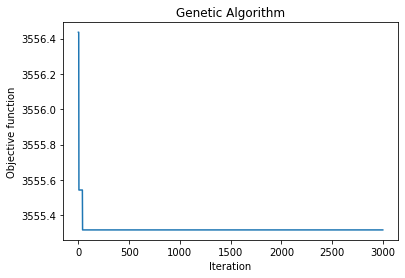

In [133]:
varbound=np.array([[0,10]]*N)
model=ga(function=f_celu,dimension=N,variable_type='real',variable_boundaries=varbound)
model.run()